# Surf's Up!

In [16]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

## Reflect Tables into SQLAlchemy ORM

* Use SQLAlchemy `create_engine` to connect to your sqlite database.
* Use SQLAlchemy `automap_base()` to reflect your tables into classes and save a reference to those classes called `Station` and `Measurement`.

In [2]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [3]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [4]:
# We can view all of the classes
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [5]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [6]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [7]:
# Take a look at what we have:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [8]:
# Take a look at what we have:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [9]:
# Take a look at what we have:
columns_station = inspector.get_columns('station')
for c in columns_station:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Take a look at what we have:
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

# Climate Analysis and Exploration

## Precipitation Analysis
* Design a query to retrieve the last 12 months of precipitation data.

* Select only the `date` and `prcp` values.

* Load the query results into a Pandas DataFrame and set the index to the date column.

* Sort the DataFrame values by `date`.

* Plot the results using the DataFrame `plot` method.

* Use Pandas to print the summary statistics for the precipitation data.

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
engine.execute('SELECT max(date) FROM measurement LIMIT 10').fetchall()[0][0]

'2017-08-23'

In [28]:
# Perform a query to retrieve the data and precipitation scores
rain_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= dt.date(2017, 8 ,23) - dt.timedelta(days=365)).\
    order_by(Measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
rain_df = pd.DataFrame(rain_data)
rain_df = rain_df.set_index('date')
# Sort the dataframe by date
rain_df.sort_values(['date'], ascending=True)
rain_df.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


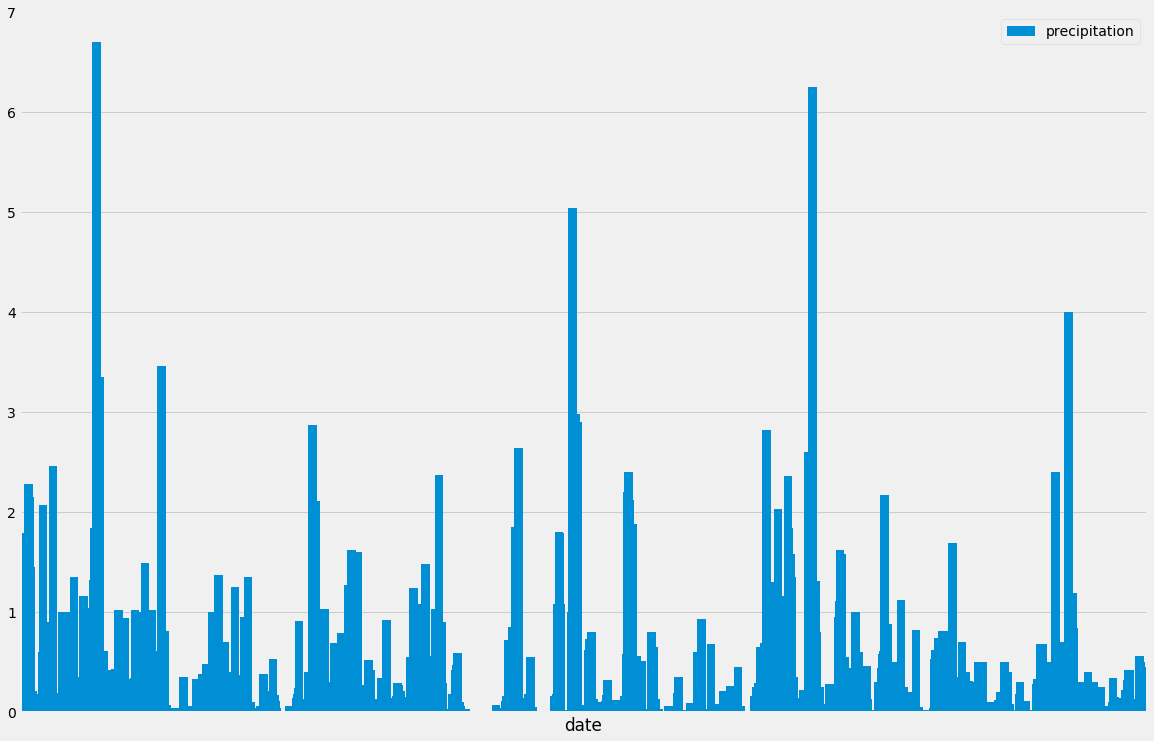

In [29]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = rain_df.plot.bar(width=17)
ax.set_xticks([])
# plt.rcParams['figure.figsize'] = (18,12)
plt.ylim(0,7)
ax.legend(['precipitation']);

In [30]:
# Use Pandas to calculate the summary statistics for the precipitation data
rain_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis
* Design a query to calculate the total number of stations.

* Design a query to find the most active stations.

  * List the stations and observation counts in descending order.

  * Which station has the highest number of observations?

  * Hint: You may need to use functions such as `func.min`, `func.max`, `func.avg`, and `func.count` in your queries.

* Design a query to retrieve the last 12 months of temperature observation data (tobs).

  * Filter by the station with the highest number of observations.

  * Plot the results as a histogram with `bins=12`.

In [20]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station).group_by(Station.station).count()
station_count

9

In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Choose the station with the highest number of temperature observations.
highest = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).limit(1).all()
highest_station = highest[0][0]
highest_station

'USC00519281'

In [31]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tob_data = session.query(Measurement.tobs).\
    filter(Measurement.date >= dt.date(2017, 8 ,23) - dt.timedelta(days=365)).\
    filter(Measurement.station == highest_station).\
    order_by(Measurement.date).all()
tob_df = pd.DataFrame(tob_data)

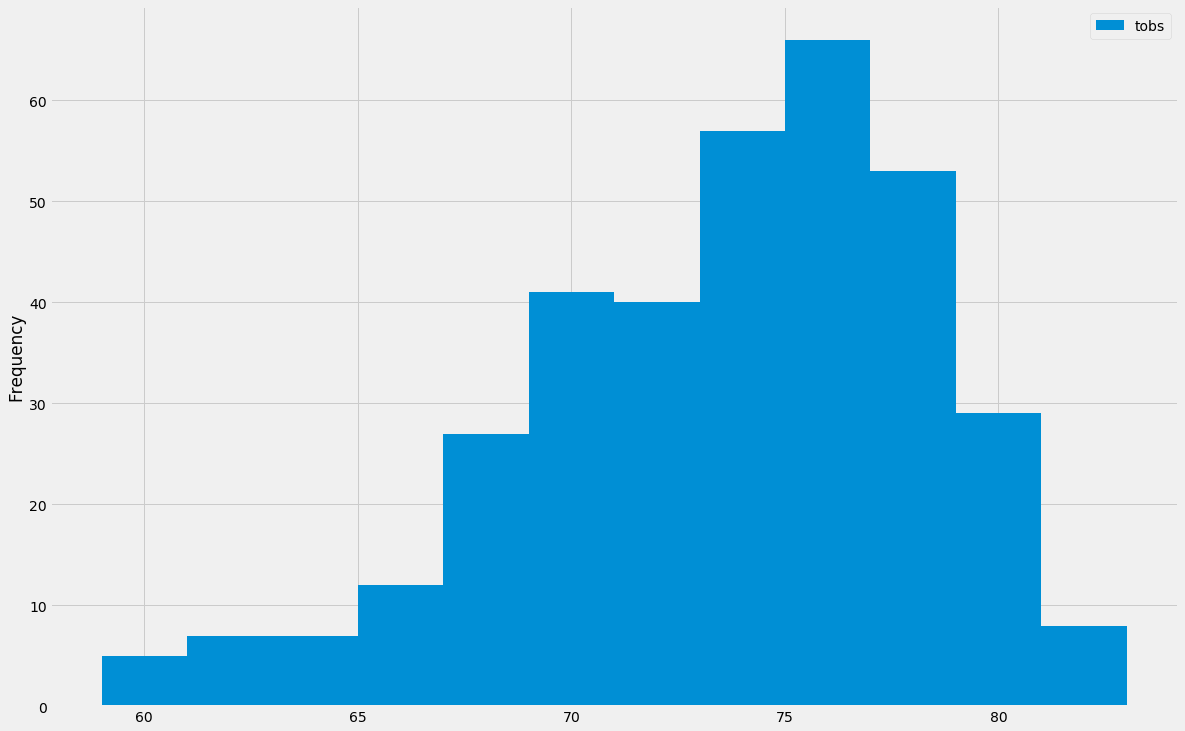

In [32]:
ax = tob_df.plot.hist(bins=12)